In [1]:
import glob
import json
import os
from pathlib import Path
import numpy as np
import pandas as pd
from siuba import group_by, summarize, arrange, filter, mutate, if_else, _
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import torch
from torchvision import transforms
from multimodal.multimodal_lit import MultiModalLitModel
import clip
from sklearn.manifold import TSNE
from PIL import Image

In [2]:
# visualize embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
normalizer = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

preprocess = transforms.Compose([
            transforms.Resize((224, 224),
                              interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            normalizer,
        ])

# load embedding checkpoint
checkpoint_name = f"multimodal_text_encoder_embedding_embedding_dim_512_batch_size_8_dropout_i_0.5_lr_0.0001_lr_scheduler_True_weight_decay_0.1_max_epochs_400_seed_0"
checkpoint = glob.glob(f"/home/wv9/code/WaiKeen/multimodal-baby/checkpoints/{checkpoint_name}/epoch*.ckpt")[0]
model = MultiModalLitModel.load_from_checkpoint(checkpoint, map_location=device)
model.eval()
print("")

In [53]:
# get image embeddings
DATA_DIR = Path("/misc/vlgscratch4/LakeGroup/shared_data/S_multimodal")
EVALUATION_FRAMES_DIR = DATA_DIR / "object_categories"
eval_categories = sorted(os.listdir(EVALUATION_FRAMES_DIR))
# eval_categories = ["tree", "apple", "dog", "pen", "microwave", "bucket", "ball", "hat",
                  # "jacket", "turtle", "cat", "button", "ring", "cake", "crib", "butterfly"]
# eval_categories = ["train", "sandwich", "phone", "knife", 
                  # "pizza", "balloon", "key", "guitar",
                  # "cookie", "pants", "bagel", "airplane",
                  # "stamp", "broom", "bike", "coin"]    

all_image_features = []
all_eval_categories = []
all_image_filenames = []

for eval_category in eval_categories:
    frames = sorted(glob.glob(os.path.join(EVALUATION_FRAMES_DIR, eval_category, "*.jpg")))
    print(eval_category, len(frames))
    
    for frame in frames:
        I = preprocess(Image.open(frame).convert('RGB')).unsqueeze(0).to(device)
        image_features, _ = model.model.encode_image(I)
        all_image_features.append(image_features.squeeze().detach().cpu().numpy())
        all_eval_categories.append(eval_category)
        all_image_filenames.append(frame)

airplane 15
apple 15
backpack 15
bagel 12
ball 15
balloon 15
basket 15
bed 15
bell 15
bench 15
bike 15
bird 14
bottle 15
bowl 15
broom 15
bucket 15
butterfly 15
button 15
cake 15
camera 15
cat 15
chair 15
cheese 15
clock 15
coin 15
cookie 15
crib 15
desk 15
dog 15
fan 15
guitar 15
hairbrush 15
hat 15
jacket 14
juice 15
kayak 14
key 15
knife 15
leaves 15
microwave 15
necklace 15
pants 15
pen 15
phone 15
pipe 15
pizza 15
ring 14
rock 15
sandwich 15
scissors 15
shoe 15
socks 15
sofa 15
spoon 15
stamp 15
stool 15
toothpaste 15
train 15
tree 15
tricycle 15
turtle 15
tv 15
umbrella 15
watch 15


In [54]:
VOCAB_FILENAME = DATA_DIR / "vocab.json"
with open(VOCAB_FILENAME) as f:
    vocab = json.load(f)
    
all_text_features = []

for eval_category in eval_categories:
    text = torch.tensor([vocab[eval_category]]).unsqueeze(0).to(device)
    text_len = torch.tensor([len(text)], dtype=torch.long).to(device)
    text_features, _ = model.model.encode_text(text, text_len)
    all_text_features.append(text_features.squeeze().detach().cpu().numpy())

In [55]:
# get mean image embeddings
all_image_features = np.array(all_image_features)
mean_image_features = []

for i in range(len(eval_categories)):
    idxs = [j for j in range(len(all_eval_categories)) if all_eval_categories[j] == eval_categories[i]]
    curr_image_features = all_image_features[idxs]
    curr_mean_image_features = np.mean(curr_image_features, axis=0)
    mean_image_features.append(curr_mean_image_features)

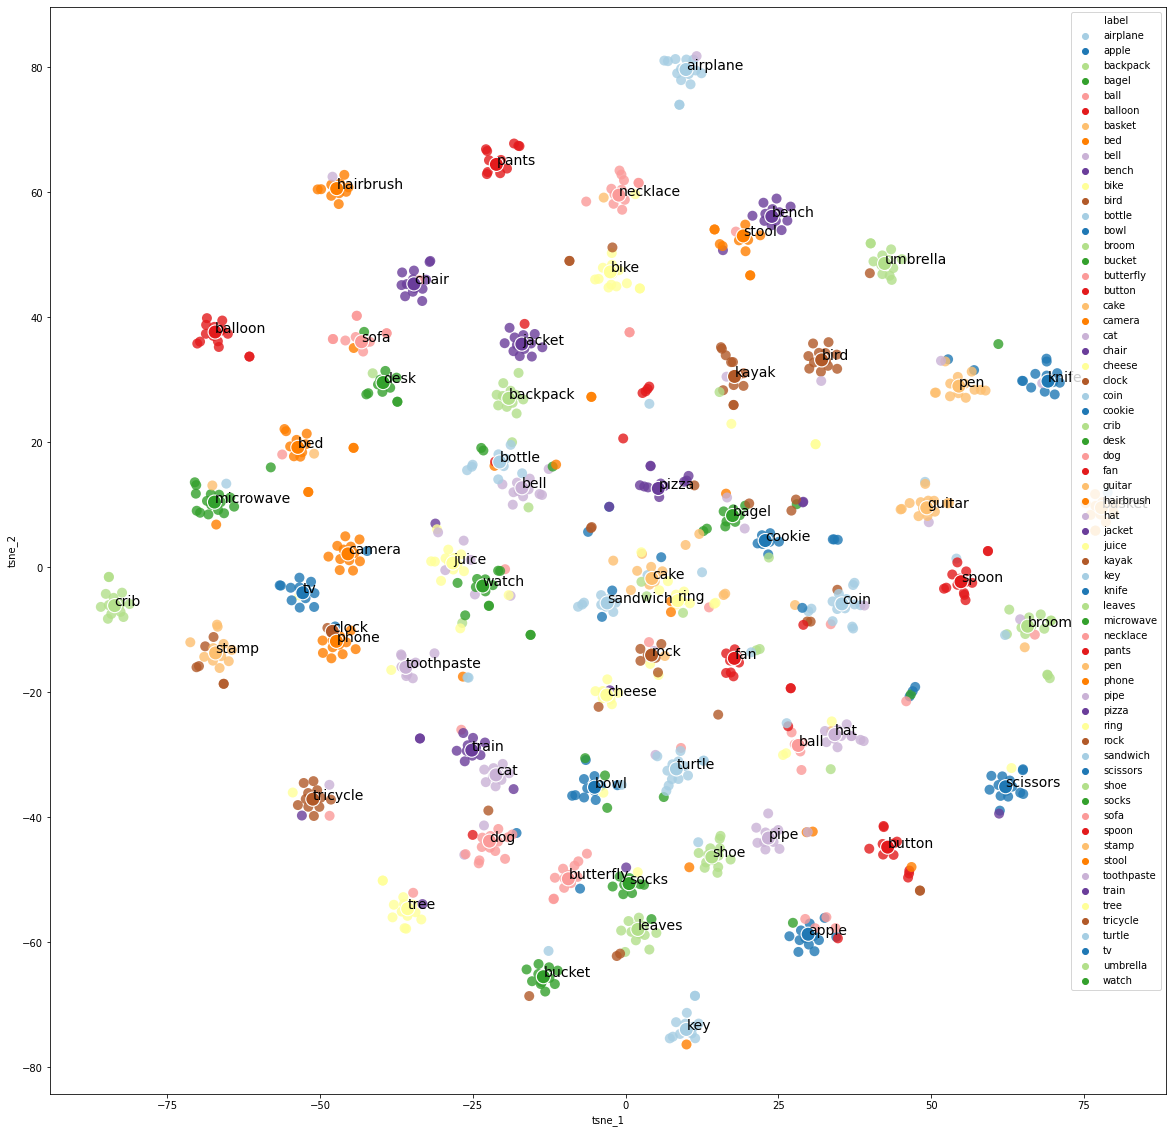

In [56]:
# plot image embeddings
n_components = 2
tsne = TSNE(n_components, perplexity=2)
all_mean_image_features = np.concatenate([all_image_features, mean_image_features])
tsne_result = tsne.fit_transform(all_mean_image_features)
all_tsne_result = tsne_result[:-len(eval_categories)]
mean_tsne_result = tsne_result[-len(eval_categories):]
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': all_tsne_result[:,0], 'tsne_2': all_tsne_result[:,1], 'label': all_eval_categories})
mean_tsne_result_df = pd.DataFrame({'tsne_1': mean_tsne_result[:,0], 'tsne_2': mean_tsne_result[:,1], 'label': eval_categories})
fig = plt.figure(figsize=(20, 20))

ax = plt.gca()
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, s=100, legend="auto", palette="Paired", linewidth=0, alpha=0.8)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=mean_tsne_result_df, s=200, legend=False, palette="Paired")
lim = (tsne_result.min()-5, tsne_result.max()+5)
for i, eval_category in enumerate(eval_categories):
    ax.text(mean_tsne_result[i, 0], mean_tsne_result[i, 1], eval_category, size=14)

/home/wv9/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


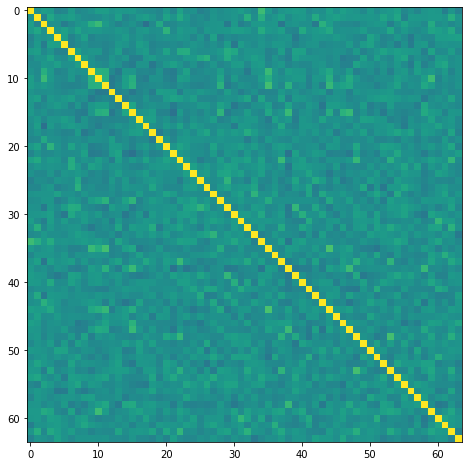

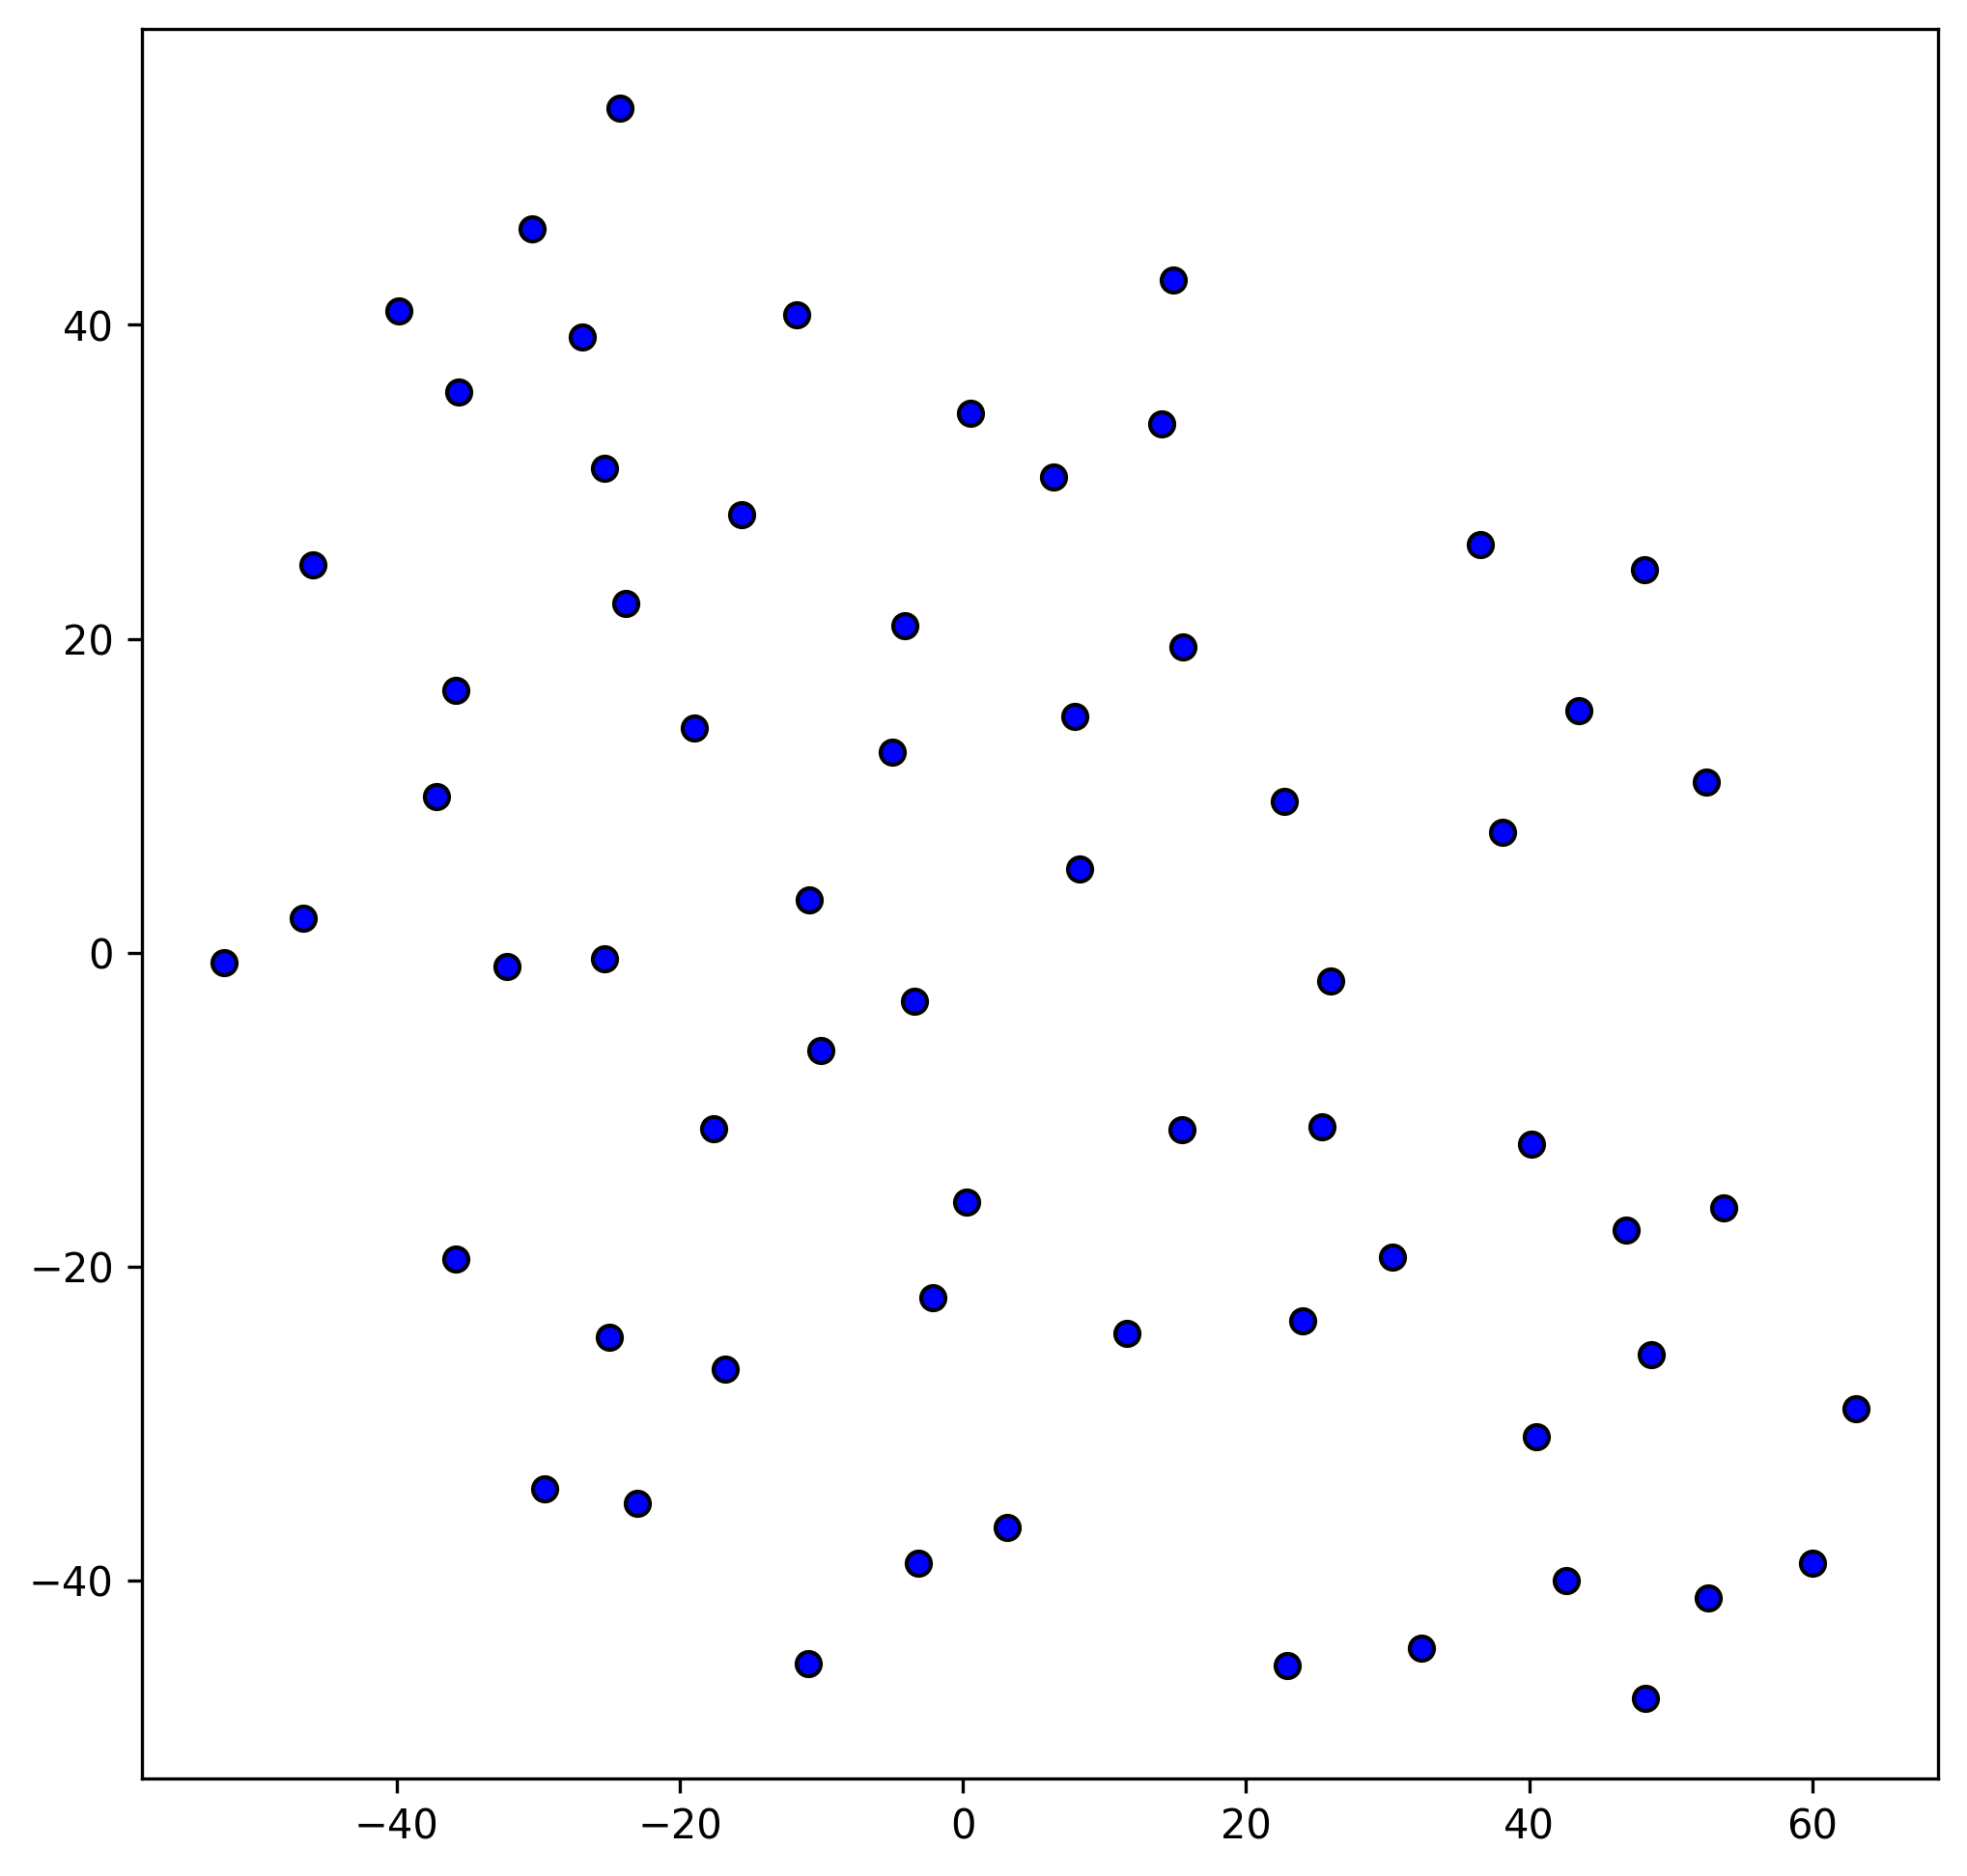

In [59]:
from sklearn import manifold

import torch.nn.functional as F

# combined_features = np.concatenate([mean_image_features, all_text_features])
# print(combined_features.shape)
combined_features = []
for i in range(len(eval_categories)):
    # combined_features.append(mean_image_features[i])
    combined_features.append(all_text_features[i])
combined_features = np.array(combined_features)
        
combined_sims = np.zeros((len(combined_features), len(combined_features)))
for i in range(len(combined_features)):
    for j in range(len(combined_features)):
        x1 = F.normalize(torch.Tensor(combined_features[i]), p=2, dim=0)
        x2 = F.normalize(torch.Tensor(combined_features[j]), p=2, dim=0)
        combined_sims[i, j] = torch.nn.functional.cosine_similarity(x1, x2, dim=0)  

plt.figure(figsize=(8, 8))
plt.imshow(combined_sims, vmin=-1, vmax=1)  

# set-up t-sne model
tsne_model = manifold.TSNE(random_state=1, metric="precomputed", perplexity=20)

# normalize similarity scores to be between 0 and 1
normalized_sims = (combined_sims-np.min(combined_sims))/(np.max(combined_sims)-np.min(combined_sims))

# invert similarity scores since t-sne takes in a distance matrix
Y = tsne_model.fit_transform(1 - normalized_sims)

plt.figure(figsize=(8, 8), dpi=300)
# for i in range(0, len(Y), 2):
#     plt.plot(Y[i:i+2, 0], Y[i:i+2, 1], '--', color="black")

for i in range(0, len(Y)):
    # if i % 2 == 0:
        # plt.scatter(Y[i, 0], Y[i, 1], color="red")
    # else:
    plt.scatter(Y[i, 0], Y[i, 1], color="blue", edgecolors= "black")

for i, eval_category in enumerate(eval_categories):
    # plt.annotate(eval_category, ((Y[2*i, 0]+Y[(2*i)+1, 0])/2, (Y[2*i, 1]+Y[(2*i)+1, 1])/2))    
    plt.annotate(eval_category, (Y[i, 0], (Y[i, 1])))    

1024


<AxesSubplot:ylabel='Density'>

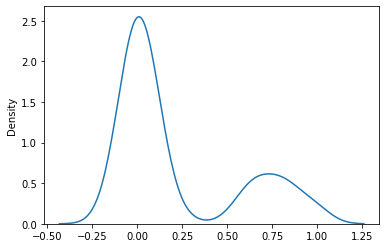

In [52]:
print(len(combined_sims.flatten()))
sns.kdeplot(combined_sims.flatten())